# MAPIE - How to use MAPIE for your own model
## Use Case: Intent Classification with a LM BERT model from Transformers HF package
***

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import copy, deepcopy

import warnings
warnings.filterwarnings("ignore")

from utils.config import SMALL_FIGSIZE, MEDIUM_FIGSIZE, LARGE_FIGSIZE

### I) Obtain data and split it into train, calibration and validation datasets

In [2]:
from datasets import load_dataset
from utils.data.dnd_style_intents import sample_and_split_dataset, get_dataframe, get_X_y
from utils.data.dnd_style_intents import FEATURES, LABEL, TARGET, PREDICTION, SET, SET_LABEL


nb_train, nb_calib, nb_test = 1000, 100, 100

dataset = load_dataset("neurae/dnd_style_intents")
ds_train, ds_calib, ds_test = sample_and_split_dataset(dataset, nb_calib=nb_calib, nb_test=nb_test)
df_train, df_calib, df_test = get_dataframe(ds_train, ds_calib, ds_test)
(X_train, y_train), (X_calib, y_calib), (X_test, y_test) = get_X_y(df_train, df_calib, df_test)

### II) Obain the LM BERT model

In [3]:
from transformers import pipeline
from utils.data.dnd_style_intents import get_label_mapping

pipe = pipeline("text-classification", model="neurae/bert-dnd-intents", device=0)
idx2lab, lab2idx, label_list = get_label_mapping(df_train)

### III) Show an inference with the LM BERT model

In [4]:
# Show some examples
X_instr = 'Could you send these metting details at 6pm?'
y_pred_instr = pipe(X_instr, top_k=2)
print(y_pred_instr)

[{'label': 'Message', 'score': 0.9945846199989319}, {'label': 'Exchange', 'score': 0.0019817615393549204}]


***
## MAPIE: model training, calibration and prediction (MAPIE/scikit-learn routine)
### 1) Run the 4 steps of the MAPIE routine

The MAPIE routine is composed of 4 steps:
1. Identify a (pre-trained) model.
2. Wrap it with the MAPIE class:
   - Choose the non-conformity score.
   - and compute conformity scores on calibration data.
3. Predict the target on the test data to obtain the prediction sets.

This routine is comparable to that of any scikit-learn-compatible estimator.

In [5]:
import numpy as np
from mapie.classification import MapieClassifier
from mapie.conformity_scores import LACConformityScore
from utils.model import MapieFromTransformers


# 1) Get main predictor.
kwargs_predictor={'lab2idx': lab2idx}
clf = MapieFromTransformers(estimator=pipe, **kwargs_predictor)

# 2) Get the non-conformity score.
kwargs_score={}
csf = LACConformityScore(**kwargs_score)

# 3) Conformalize the main predictor (wrap with MAPIE conformal class).
kwargs_conformalizer={'conformity_score': csf, 'cv': 'prefit'}  # split conformal setting
mapie_classifier = MapieClassifier(estimator=clf, **kwargs_conformalizer)
mapie_classifier = mapie_classifier.fit(X_calib, y_calib)

# 4) Obtain predictions and sets of predictions.
alpha = 0.2
alpha_list = np.array([alpha])
kwargs_predict = {}  # {'include_last_label': 'randomized'}
y_pred, y_pis = mapie_classifier.predict(X_test, alpha=alpha_list, **kwargs_predict)
y_proba = clf.predict_proba(X_test)

AttributeError: 'MapieFromTransformers' object has no attribute 'lab2idx'

### Visualiser les résultats

### Give an illustration

In [ ]:
pd.DataFrame([(x[0], idx2lab[y]) for x, y in zip(X_test, y_test)])

,0,1
0,Your business is to carry socks to workers.,Deliver
1,Your target is to deliver knife to Hargrimm th...,Deliver
2,Could you deliver report to workers?,Message
3,Can you take agility poition to Alaric Wiseham...,Deliver
4,I finished my task in Faeglenest.,Complete quest
...,...,...
245,wizard hundred mxcvxjjjfsk hunter bfdbf geniou...,Drival
246,"Welcome to Sara Starwatcher's world, friends!",Greeting
247,"Give me shuriken, scythe.",Exchange
248,bring report over to that gnome.,Message


When mapie.fit, compute the mapie_classifier.conformity_scores_

When mapie.predict, compute the mapie_classifier.quantiles_

In [ ]:
# Get all the results in a dataframe
pd_results = pd.DataFrame({
    TARGET: df_test[TARGET],
    LABEL: df_test[LABEL],
    PREDICTION: y_pred,
    'y_test_proba': np.take_along_axis(np.array(y_proba), np.array(y_test).reshape(-1, 1), axis=1)[:,0],
    'y_pred_proba': np.take_along_axis(np.array(y_proba), np.array(y_pred, dtype=int).reshape(-1, 1), axis=1)[:,0],
    'width': np.sum(y_pis[:,:,0], axis=-1),
    'covered': np.take_along_axis(np.array(y_pis[:,:,0]), np.array(y_test, dtype=int).reshape(-1, 1), axis=1)[:,0]
})

In [ ]:
# Round alpha to the closest value in the list
alpha_dict = {np.round(alpha, 2): i for i, alpha in enumerate(alpha_list)}
# Compute alpha correction (adjust alpha w.r.t quantile correction)
alpha_cor_list = 1-np.clip(np.ceil((1-alpha_list)*(nb_calib+1))/nb_calib, a_min=0, a_max=1)

# Select alpha, index and correction for the following plots
alpha = 0.2
alpha_idx = alpha_dict[alpha]
alpha_cor = alpha_cor_list[alpha_idx]

In [ ]:
# Get the empirical quantiles for all tested alpha
quantile_dict = {np.round(alpha, 2): np.round(q, 2) for alpha, q in zip(alpha_list, mapie_classifier.quantiles_)}
# Get the empirical quantile for the selected alpha
quantile = quantile_dict[alpha]

0.0


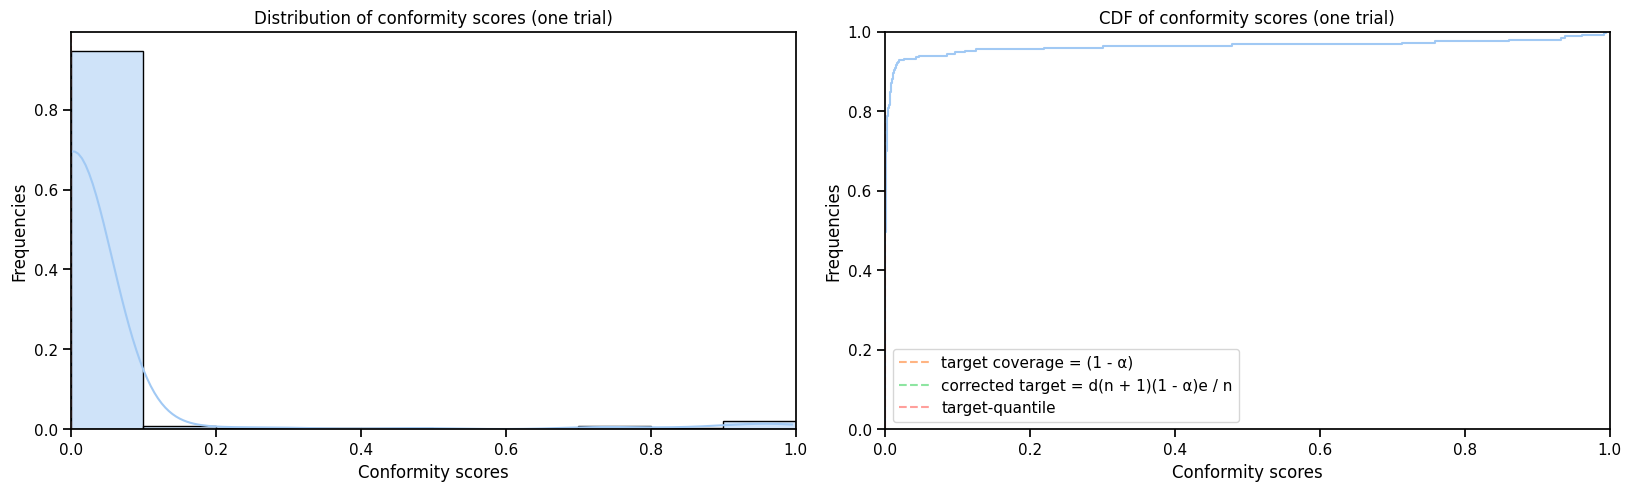

In [ ]:
from utils.plot import plot_conformity_score_distribution

# Get the empirical conformity scores distribution (based on the calibration set)
conformity_scores = mapie_classifier.conformity_scores_.flatten()

# Plot its empirical distribution and its empirical cumulative distribution function (ECDF)
kwargs_hist = {'bins': 10, 'binrange': [0, 1]}
kwargs_ecdf = {}
plot_conformity_score_distribution(
    conformity_scores, quantile, alpha, alpha_cor,
    figsize=LARGE_FIGSIZE, kwargs_hist=kwargs_hist, kwargs_ecdf=kwargs_ecdf
)

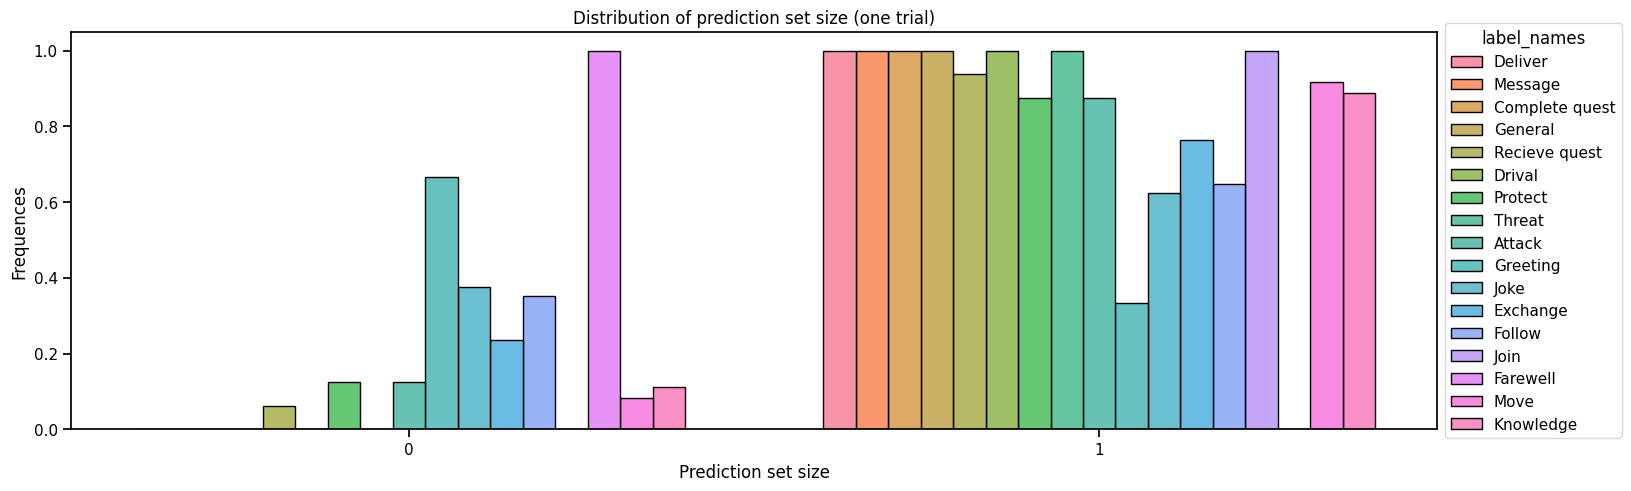

In [ ]:
from utils.plot import plot_size_set_distribution

# Get the size of the prediction sets for each test sample
size_sets = np.sum(y_pis[:,:,alpha_idx], axis=-1)
pd_results['size_set'] = size_sets

# Plot the empirical distribution of the size of the prediction sets
kwargs = {'discrete': True, 'multiple': 'dodge', 'shrink': 0.8}
plot_size_set_distribution(pd_results, label=LABEL, figsize=LARGE_FIGSIZE, hue=LABEL, **kwargs)

In [ ]:
X_instr = [['Could you send these metting details to my sister at 6pm?']]
y_pred_instr, y_pis_instr = mapie_classifier.predict(
    X_instr, alpha=0.2, **kwargs_predict
)
print(idx2lab[int(y_pred_instr)])
print([idx2lab[i] for i, cond in enumerate(y_pis_instr[0,:,0]) if cond])

Message
['Message']


### Among differents reasponses, how are we good? Are there some disparities?

In [ ]:
from sklearn.metrics import accuracy_score
from mapie.metrics import classification_coverage_score, classification_mean_width_score

coverage_ = []
accuracy_ = []
set_size_ = []
number_obs_ = []

idx_size_ = [idx for idx, item in enumerate(pd_results[LABEL])]
y_test_ = pd_results[TARGET][idx_size_]
y_preds_ = pd_results[PREDICTION][idx_size_]
y_pss_ = y_pis[idx_size_, :, 0]

number_obs_.append(len(idx_size_))
accuracy_.append(accuracy_score(y_test_, y_preds_))
coverage_.append(classification_coverage_score(y_test_, y_pss_))
set_size_.append(classification_mean_width_score(y_pss_))

# Compute metrics for each group (coverage, accuracy, number of observations)
for label in label_list:
    idx_size_ = [idx for idx, item in enumerate(pd_results[LABEL]) if item == label]
    y_test_ = pd_results[TARGET][idx_size_]
    y_preds_ = pd_results[PREDICTION][idx_size_]
    y_pss_ = y_pis[idx_size_, :, 0]

    number_obs_.append(len(idx_size_))
    accuracy_.append(accuracy_score(y_test_, y_preds_))
    coverage_.append(classification_coverage_score(y_test_, y_pss_))
    set_size_.append(classification_mean_width_score(y_pss_))


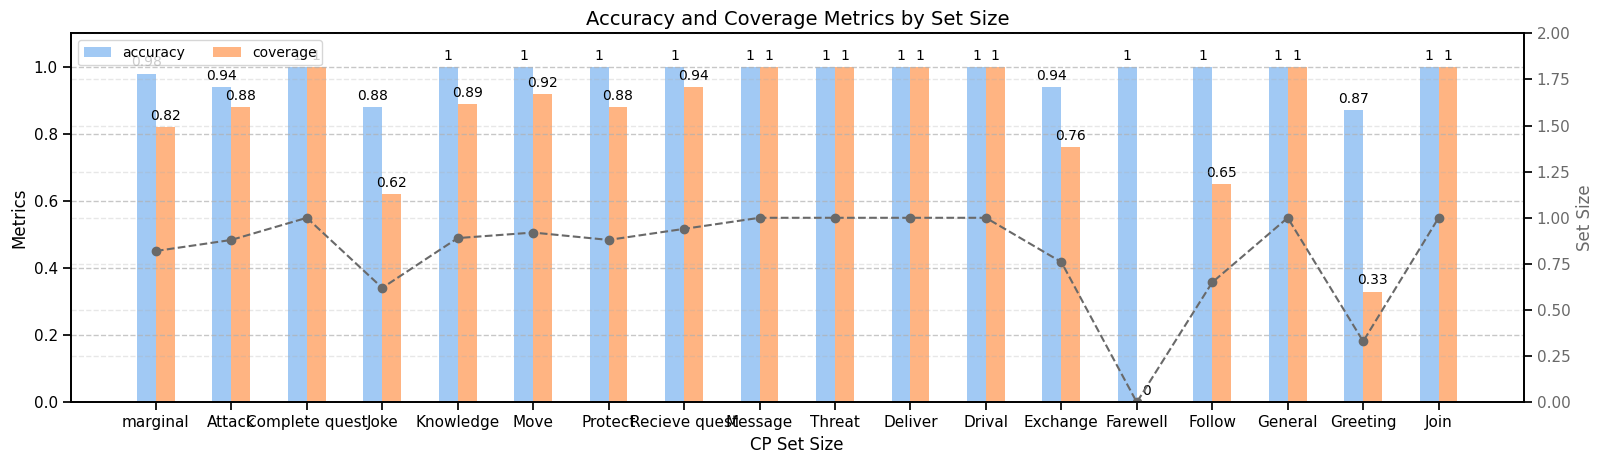

In [ ]:
from utils.plot import plot_metrics_inside_groups

metrics = {
    'accuracy': tuple(np.round(accuracy_, 2)),
    'coverage': tuple(np.round(coverage_, 2)),
    'set size': tuple(np.round(set_size_, 2)),
}

# Plot metrics for each group (coverage, accuracy, number of observations)
plot_metrics_inside_groups(metrics, ['marginal'] + label_list, number_obs_, figsize=LARGE_FIGSIZE)

### Compare performance AI vs human

In [ ]:
# Get all the results in a dataframe
pd_results = pd.DataFrame({
    TARGET: df_test[TARGET],
    LABEL: df_test[LABEL],
    PREDICTION: y_pred,
    'y_test_proba': np.take_along_axis(np.array(y_proba), np.array(y_test).reshape(-1, 1), axis=1)[:,0],
    'y_pred_proba': np.take_along_axis(np.array(y_proba), np.array(y_pred).reshape(-1, 1), axis=1)[:,0],
    'width': np.sum(y_pis[:,:,0], axis=-1),
    'covered': np.take_along_axis(np.array(y_pis[:,:,0]), np.array(y_test).reshape(-1, 1), axis=1)[:,0]
})

In [ ]:
pd_results

,labels,label_names,predictions,y_test_proba,y_pred_proba,width,covered
0,9,Deliver,9,0.999619,0.999619,1,True
1,9,Deliver,9,0.999543,0.999543,1,True
2,7,Message,7,0.999637,0.999637,1,True
3,9,Deliver,9,0.999639,0.999639,1,True
4,1,Complete quest,1,0.999901,0.999901,1,True
...,...,...,...,...,...,...,...
245,10,Drival,10,0.999766,0.999766,1,True
246,15,Greeting,15,0.997794,0.997794,1,True
247,11,Exchange,11,0.999023,0.999023,1,True
248,7,Message,7,0.999682,0.999682,1,True


In [ ]:
human_cost = 10
ai_cost = 1

# Compute the cost of each prediction set for each test sample
pd_results['cost'] = pd_results['width'] * ai_cost + (1 - pd_results['width']) * human_cost

### How to deal with this problem?